In [1]:
import torch

print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
print(f"当前GPU设备: {torch.cuda.current_device()}")
print(f"设备名称: {torch.cuda.get_device_name(0)}")  # 假设使用第0块GPU


PyTorch版本: 2.6.0+cu124
CUDA是否可用: True
当前GPU设备: 0
设备名称: NVIDIA GeForce RTX 2070 SUPER


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
# 读取训练数据和测试数据
train_data = pd.read_csv(r'house-prices-advanced-regression-techniques\train.csv')  # 训练数据
test_data = pd.read_csv(r'house-prices-advanced-regression-techniques\test.csv')    # 测试数据


In [5]:
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [6]:
# 打印训练数据的前4行，选择部分列进行显示
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) # 合并训练和测试数据，去掉ID列和SalePrice列
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])  # 打印合并后的数据的前4行，选择部分列进行显示
print(all_features.shape)
print(type(all_features))

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml
(2919, 79)
<class 'pandas.core.frame.DataFrame'>


In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 选择数值型特征
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())  # 标准化数值型特征
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)  # 填充缺失值为0
all_features = pd.get_dummies(all_features, dummy_na=True)  # 将分类特征转换为独热编码
print(all_features.shape)  # 打印处理后的数据的形状

(2919, 330)


In [8]:
all_features = all_features * 1.0  # 将数据转换为浮点数类型
print(all_features)

      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1      -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2       0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3       0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
4       0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
...          ...          ...       ...          ...          ...        ...   
1454    2.419286    -2.069222 -1.043758    -1.481667     1.289537  -0.043338   
1455    2.419286    -2.069222 -1.049083    -1.481667    -0.507197  -0.043338   
1456   -0.873466     3.884968  1.246594    -0.772420     1.289537  -0.373465   
1457    0.655311    -0.312950  0.034599    -0.772420    -0.507197   0.682939   
1458    0.067320     0.201080 -0.068608     0.646073    -0.507197   0.715952   

      YearRemodAdd  MasVnrArea  BsmtFin

In [9]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示

n_train = train_data.shape[0]  # 训练数据的样本数量
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)  # 训练特征
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)  # 测试特征
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float32)  # 训练标签
print(train_labels[:4])  # 打印训练标签的前4个值

tensor([208500., 181500., 223500., 140000.])


In [10]:
loss = nn.MSELoss()  # 均方误差损失函数
print(loss(train_labels, train_labels))  # 打印损失函数的计算结果
in_features = train_features.shape[1]  # 输入特征的维度
print(in_features)

tensor(0.)
330


In [11]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))  # 定义一个线性回归模型
    return net

In [12]:
def log_rmse(net, features, labels):
    # 计算对数均方根误差
    with torch.no_grad():
        clipped_preds = torch.clamp(net(features), 1, float('inf'))
        rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))  # 计算均方根误差
    return rmse.item()

In [13]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs=100, learning_rate=0.01, weight_decay=0, batch_size=16):
    
    # 训练模型
    train_labels = train_labels.reshape(-1, 1) # 将训练标签转换为列向量

    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)  # 创建训练数据迭代器
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adam优化器
    
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()  # 清空梯度
            l = loss(net(X), y)
            l.backward()  # 反向传播计算梯度
            optimizer.step()  # 更新参数
        train_ls.append(log_rmse(net, train_features, train_labels))  # 评估阶段
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))  # 计算测试集的均方根误差
    return train_ls, test_ls  # 返回训练和测试的均方根误差

In [14]:
net = get_net()  # 获取模型
num_epochs = 100  # 训练轮数    
batch_size = 64  # 批量大小
lr = 20  # 学习率
weight_decay = 0  # 权重衰减
train_ls, test_ls = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
print(train_ls)  # 打印训练集的均方根误差

[2.169245719909668, 1.5026835203170776, 1.1315090656280518, 0.8821581602096558, 0.7016718983650208, 0.5648767948150635, 0.45939958095550537, 0.3790930211544037, 0.3165684938430786, 0.26944398880004883, 0.2350161224603653, 0.2110217809677124, 0.1943151205778122, 0.18337582051753998, 0.1766158640384674, 0.17225585877895355, 0.1698051244020462, 0.16828367114067078, 0.16752560436725616, 0.16746531426906586, 0.16713187098503113, 0.16729465126991272, 0.167051762342453, 0.16724391281604767, 0.16629678010940552, 0.16499902307987213, 0.16546663641929626, 0.16384345293045044, 0.1624194085597992, 0.16052398085594177, 0.15927861630916595, 0.1584842950105667, 0.1564464569091797, 0.15599265694618225, 0.15496934950351715, 0.15294641256332397, 0.15228316187858582, 0.15157067775726318, 0.15070368349552155, 0.14904791116714478, 0.14842194318771362, 0.147678405046463, 0.14654339849948883, 0.14623123407363892, 0.14516621828079224, 0.14444993436336517, 0.1443234533071518, 0.14314378798007965, 0.14265215396

In [15]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    # 将数据划分为k折
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) if j != i else None
        X_part, y_part = X[idx], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part   # 验证集
        elif X_train is None:
            X_train, y_train = X_part, y_part  # 训练集
        else:
            X_train = torch.cat((X_train, X_part), 0)   # 合并训练集
            y_train = torch.cat((y_train, y_part), 0)   # 合并训练标签
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    # K折交叉验证
    y_train = y_train.reshape(-1, 1)  # 将训练标签转换为列向量
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)  # 获取K折数据
        net = get_net()  # 获取模型
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # 训练模型
        train_l_sum += train_ls[-1]  # 累加训练损失
        valid_l_sum += valid_ls[-1]  # 累加验证损失
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse',
                    xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k  # 返回平均训练和验证损失

fold 1, train log rmse 0.128884, valid log rmse 0.133549
fold 2, train log rmse 0.124002, valid log rmse 0.129222
fold 3, train log rmse 0.124621, valid log rmse 0.129359
fold 4, train log rmse 0.128786, valid log rmse 0.131104
fold 5, train log rmse 0.120813, valid log rmse 0.131136
5-折验证：平均训练log rmse 0.125421, 平均验证log rmse 0.130874


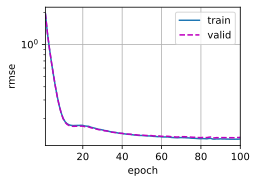

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 30, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse {float(train_l):f}, '
      f'平均验证log rmse {float(valid_l):f}')

40 0 64
训练log rmse：0.124553


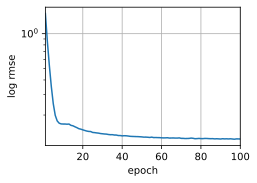

In [18]:


def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)  # 保存预测结果为CSV文件

lr, weight_decay, batch_size = 40, 0, 64  # 学习率、权重衰减和批量大小
print(lr, weight_decay, batch_size)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)